# Сборный проект — 2

## Описание проекта

### Проблема

    HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.

    Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. 

    Собирать данные такими опросниками не так легко: компания большая, и всех сотрудников надо сначала  оповестить об опросе, а затем проследить, что все его прошли. 

### Цель исследования
* Избежать отток сотрудников и финансовые потери

### Задачи исследования
1. предсказание уровня удовлетворённости сотрудника

2. предсказание увольнения сотрудника из компании

### Исходные данные
__Задача 1__
* train_job_satisfaction_rate.csv - тренировочная выборка

* test_features.csv - входные признаки тестовой выборки

* test_target_job_satisfaction_rate.csv - целевой признак тестовой выборки

__Задача 2__
* train_quit.csv - тренировочная выборка

* test_features.csv - входные признаки тестовой выборки

* test_target_quit.csv - целевой признак тестовой выборки

### План проекта

2. Подключение библиотек

__Задача 1__

3. Загрузка данных
4. Предобработка данных
5. Исследовательский анализ данных
6. Подготовка данных
7. Обучение моделей
8. Вывод

__Задача 2__

9. Загрузка данных
10. Предобработка данных
11. Исследовательский анализ данных
12. Добавление нового входного признака
13. Подготовка данных
14. Обучение моделей
15. Вывод

## Подключение библиотек

In [192]:
import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import make_scorer, roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns

## Загрузка данных (1)

In [193]:
train_job_satisfaction_rate = pd.read_csv('datasets/train_job_satisfaction_rate.csv')
test_features = pd.read_csv('datasets/test_features.csv')
test_target_job_satisfaction_rate = pd.read_csv('datasets/test_target_job_satisfaction_rate.csv')

In [194]:
train_job_satisfaction_rate.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [195]:
test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [196]:
test_target_job_satisfaction_rate.head()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


In [197]:
test = pd.merge(test_features, test_target_job_satisfaction_rate, on='id')

In [198]:
train_job_satisfaction_rate = train_job_satisfaction_rate.set_index('id')

In [199]:
train_job_satisfaction_rate.head(1)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
155278,sales,junior,medium,2,no,no,1,24000,0.58


In [200]:
test = test.set_index('id')

In [201]:
test.head(1)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,0.79


## Предобработка данных

### Пропуски

Функция для обработки пропусков

In [202]:
def passes(df):
    print("Пропуски:")
    print(df.isnull().sum())
    print("Количество записей:", df.shape[0])

In [203]:
passes(train_job_satisfaction_rate)

Пропуски:
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64
Количество записей: 4000


Пайплайн для обработки пропусков

In [204]:
passes_pipe = Pipeline(
    [
        (
            'simpleImputer_1', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent'),
        )
    ]
)    

In [205]:
col = train_job_satisfaction_rate.columns
res = passes_pipe.fit_transform(train_job_satisfaction_rate)
train_job_satisfaction_rate = pd.DataFrame(res, columns=col)

In [206]:
passes(train_job_satisfaction_rate)

Пропуски:
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64
Количество записей: 4000


Видим, что пропуски были заполнены

In [207]:
passes(test)

Пропуски:
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64
Количество записей: 2000


In [208]:
col = test.columns
res = passes_pipe.transform(test)
test = pd.DataFrame(res, columns=col)

In [209]:
passes(test)

Пропуски:
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64
Количество записей: 2000


### Неявные дубликаты

Проверим данные на неявные дубликаты

In [210]:
def implicit_duplicates(df, columns):
    for col in columns:
        print(f'{col}: {" | ".join(map(str, df[col].unique()))}')

In [211]:
train_job_satisfaction_rate.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,sales,junior,medium,2,no,no,1,24000,0.58
1,hr,junior,high,2,no,no,5,38400,0.76
2,sales,junior,low,1,no,no,2,12000,0.11
3,technology,junior,low,4,no,no,2,18000,0.37
4,hr,junior,medium,1,no,no,3,22800,0.2


In [212]:
columns = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']

In [213]:
implicit_duplicates(train_job_satisfaction_rate, columns)

dept: sales | hr | technology | purchasing | marketing
level: junior | middle | sinior
workload: medium | high | low
last_year_promo: no | yes
last_year_violations: no | yes


In [214]:
implicit_duplicates(test, columns)

dept: marketing | hr | sales | purchasing | technology |  
level: junior | middle | sinior
workload: medium | low | high |  
last_year_promo: no | yes
last_year_violations: no | yes


### Явные дубликаты

In [215]:
def duplicated(df):
    print('Количество пропусков:', df.duplicated().sum())

In [216]:
duplicated(train_job_satisfaction_rate)

Количество пропусков: 248


In [217]:
train_job_satisfaction_rate = train_job_satisfaction_rate.drop_duplicates()
train_job_satisfaction_rate = train_job_satisfaction_rate.reset_index(drop=True)

In [218]:
duplicated(train_job_satisfaction_rate)

Количество пропусков: 0


In [219]:
duplicated(test)

Количество пропусков: 83


### Типы данных

In [220]:
train_job_satisfaction_rate.dtypes

dept                     object
level                    object
workload                 object
employment_years         object
last_year_promo          object
last_year_violations     object
supervisor_evaluation    object
salary                   object
job_satisfaction_rate    object
dtype: object

In [221]:
train_job_satisfaction_rate.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,sales,junior,medium,2,no,no,1,24000,0.58
1,hr,junior,high,2,no,no,5,38400,0.76
2,sales,junior,low,1,no,no,2,12000,0.11
3,technology,junior,low,4,no,no,2,18000,0.37
4,hr,junior,medium,1,no,no,3,22800,0.2


Изменим типы данных в некоторых таблицах

In [222]:
train_job_satisfaction_rate['employment_years'] = train_job_satisfaction_rate['employment_years'].astype('int')
train_job_satisfaction_rate['supervisor_evaluation'] = train_job_satisfaction_rate['supervisor_evaluation'].astype('int')
train_job_satisfaction_rate['salary'] = train_job_satisfaction_rate['salary'].astype('int')
train_job_satisfaction_rate['job_satisfaction_rate'] = train_job_satisfaction_rate['job_satisfaction_rate'].astype('float')

In [223]:
train_job_satisfaction_rate.dtypes

dept                      object
level                     object
workload                  object
employment_years           int64
last_year_promo           object
last_year_violations      object
supervisor_evaluation      int64
salary                     int64
job_satisfaction_rate    float64
dtype: object

In [224]:
test.dtypes

dept                     object
level                    object
workload                 object
employment_years         object
last_year_promo          object
last_year_violations     object
supervisor_evaluation    object
salary                   object
job_satisfaction_rate    object
dtype: object

In [225]:
test.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,marketing,junior,medium,2,no,no,5,28800,0.79
1,hr,junior,medium,1,no,no,4,30000,0.72
2,sales,middle,low,5,no,no,4,19200,0.64
3,sales,middle,low,6,no,no,4,19200,0.6
4,hr,middle,medium,5,no,no,5,40800,0.75


In [226]:
test['employment_years'] = test['employment_years'].astype('int')
test['supervisor_evaluation'] = test['supervisor_evaluation'].astype('int')
test['salary'] = test['salary'].astype('int')
test['job_satisfaction_rate'] = test['job_satisfaction_rate'].astype('float')

In [227]:
test.dtypes

dept                      object
level                     object
workload                  object
employment_years           int64
last_year_promo           object
last_year_violations      object
supervisor_evaluation      int64
salary                     int64
job_satisfaction_rate    float64
dtype: object

### Вывод

В этом пункте выполнили предобработку данных - заполнили пропуски, проверили на дубликаты, заменили типы данных в некоторых столбцах

## Исследовательский анализ данных (1)

### Статистический анализ

In [228]:
def build_hist(df):
    columns = df.select_dtypes(include='number').columns
    for col in columns:
        bins = round(df[col].size ** 0.5)
        plt.title(col)
        df[col].hist(bins=bins, color='#006466')
        plt.grid(True)
        plt.show()

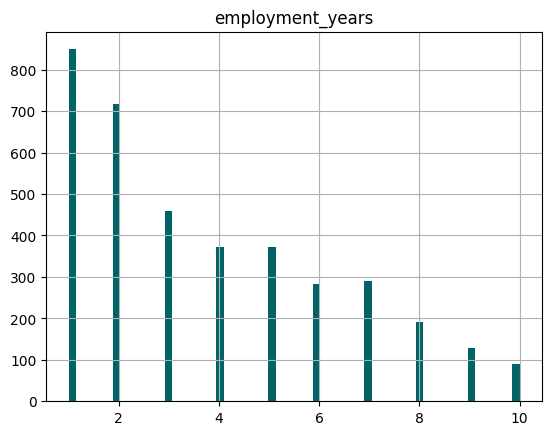

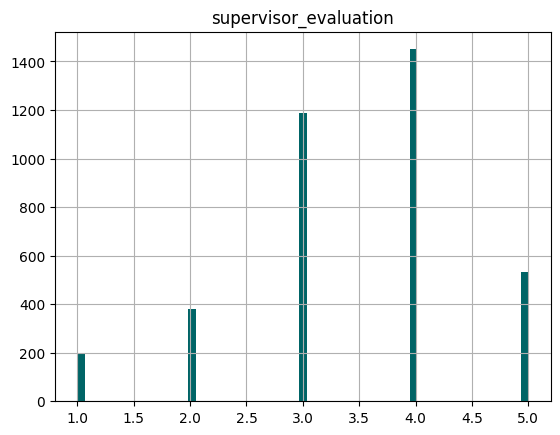

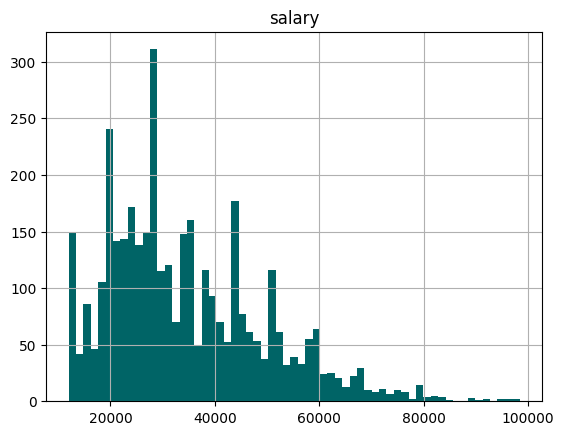

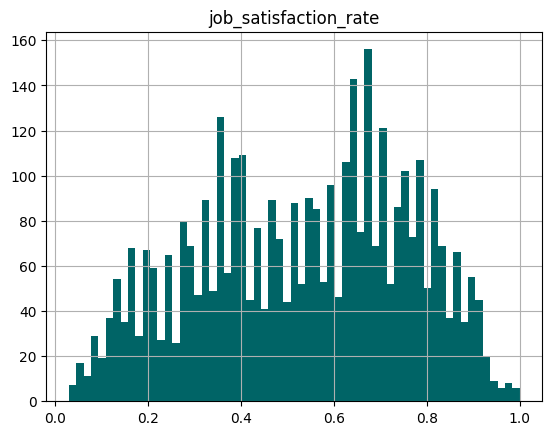

In [229]:
build_hist(train_job_satisfaction_rate)

* Большая часть работников проработала около года; 
* Оценка работников, как правило, 3-4;
* Зарплата обычно от 20к до 35к;
* Распределение уровня удовлетворенности работой примерно равномерное, но большая часть значений от 0.6 до 0.8

In [230]:
def categorical_data(df):
    columns = df.select_dtypes(exclude='number').columns
    for col in columns:
        df_table = df[col].value_counts()
        df_table.index = df[col].unique()
        pallete = ['#006466', '#3E1F47', '#212F45', '#4D194D', '#144552', '#272640']
        colors = pallete[:len(df_table)]
        df_table.plot(kind='pie', autopct='%1.1f%%', figsize=(8, 8), colors=colors)
        plt.title(col, loc='center') 
        plt.ylabel('')
        plt.show()

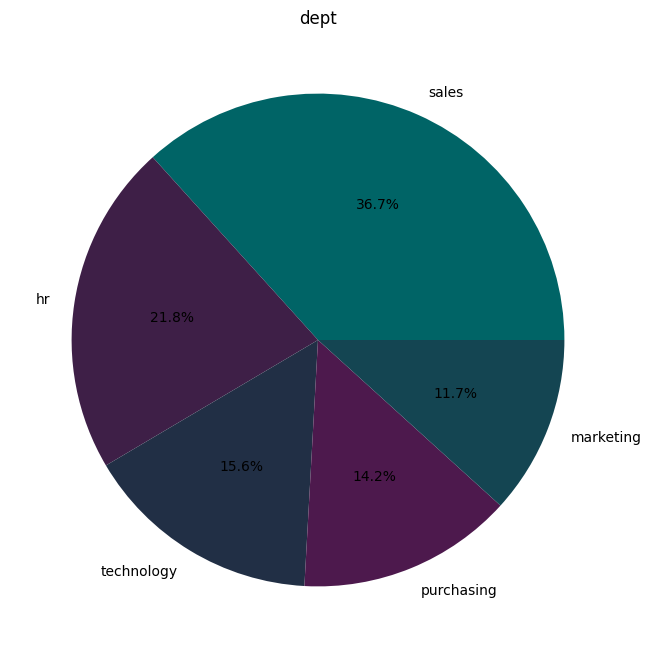

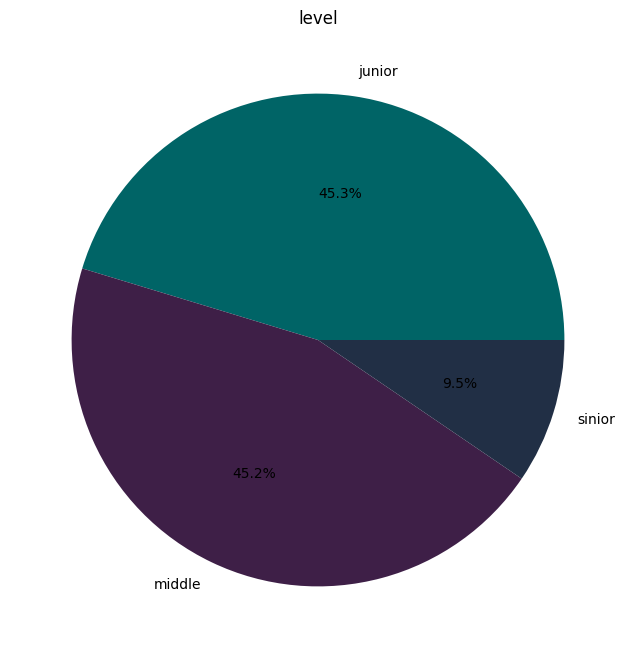

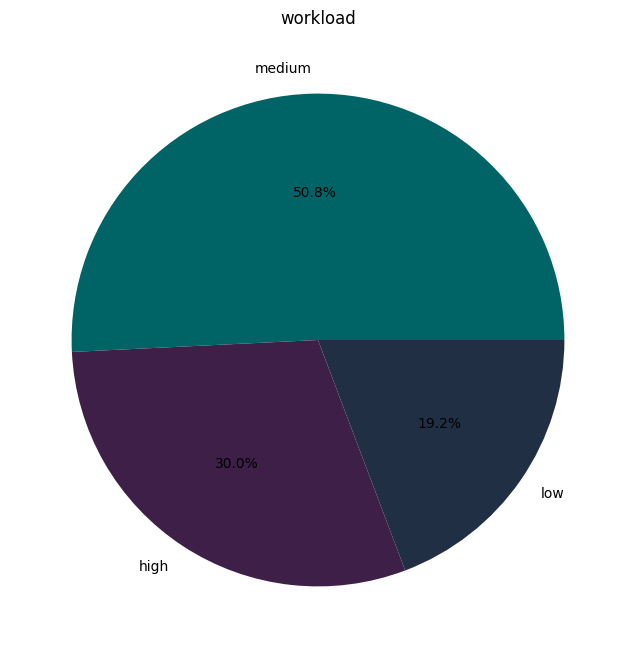

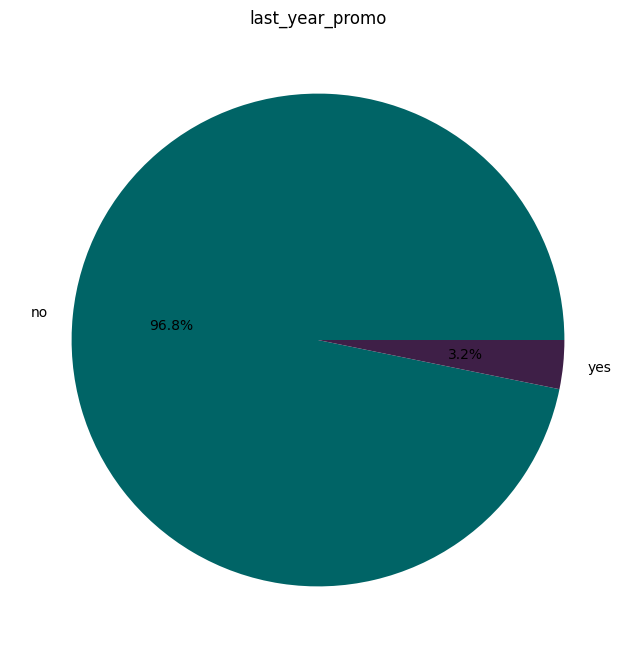

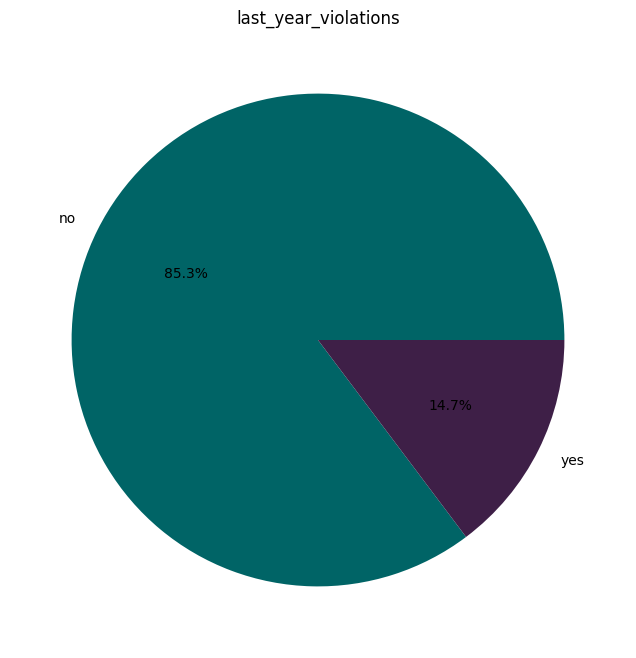

In [231]:
categorical_data(train_job_satisfaction_rate)

* Почти половина работников - начинающие специалисты;
* Обычно уровень загруженности сотрудника средний;
* За последний год у 3% сотрудников было повышение;
* 14% сотрудников нарушали трудовой договор за последний год. 

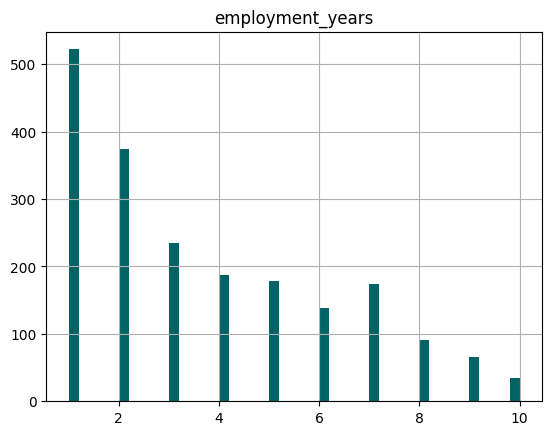

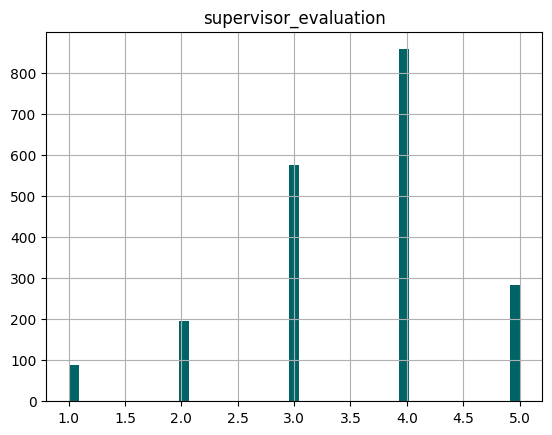

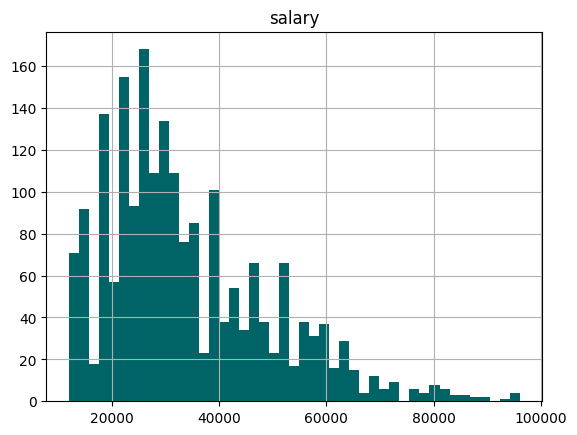

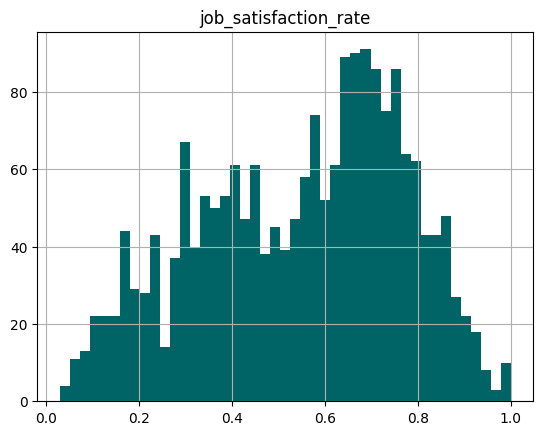

In [232]:
build_hist(test)

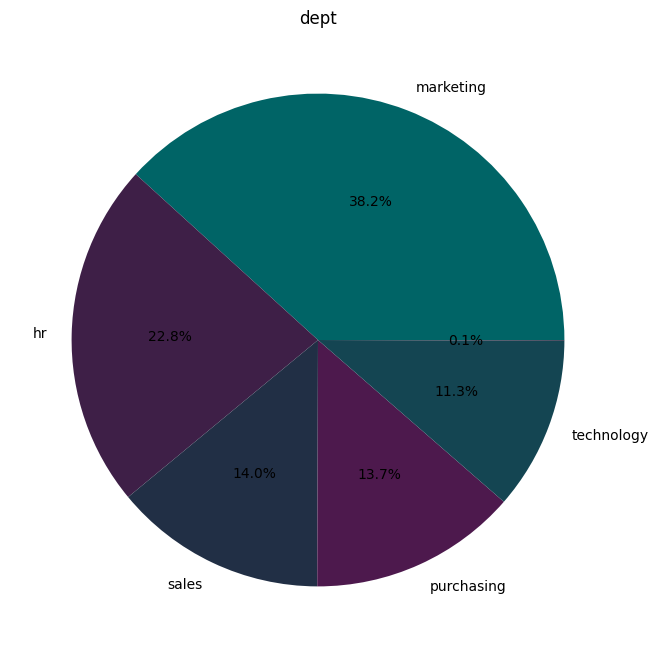

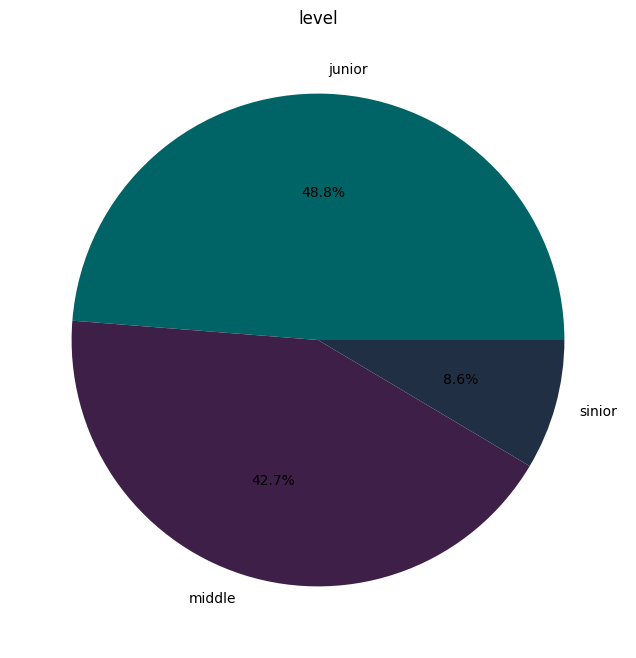

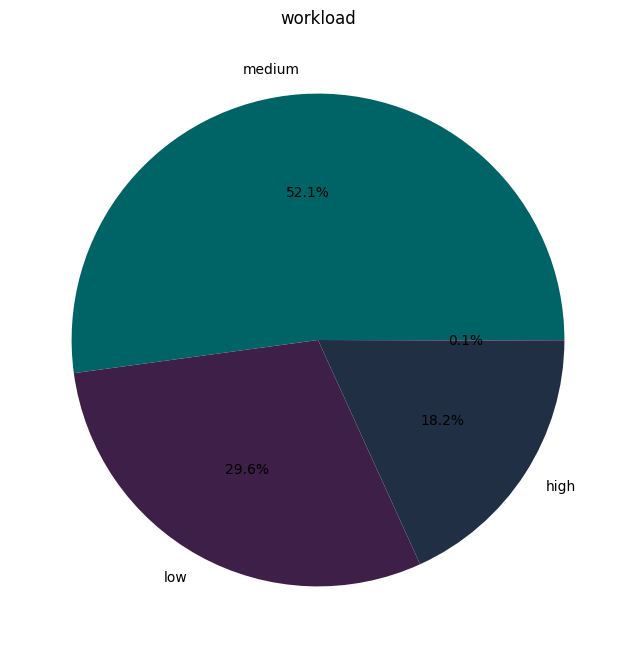

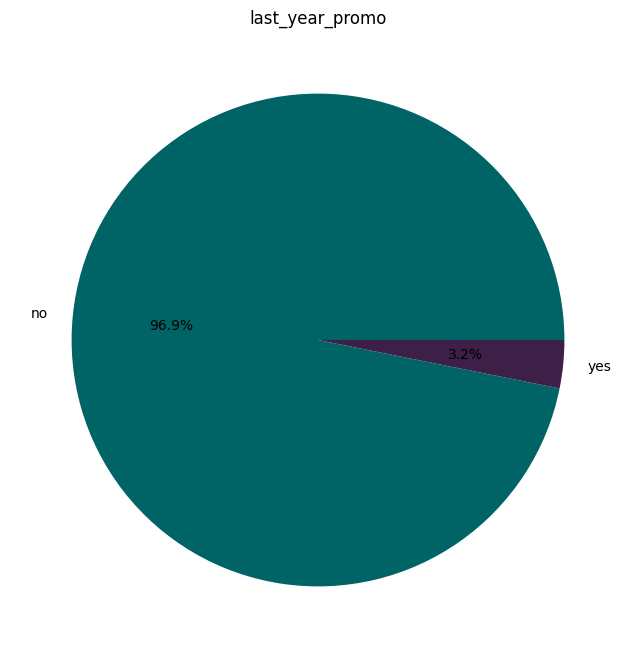

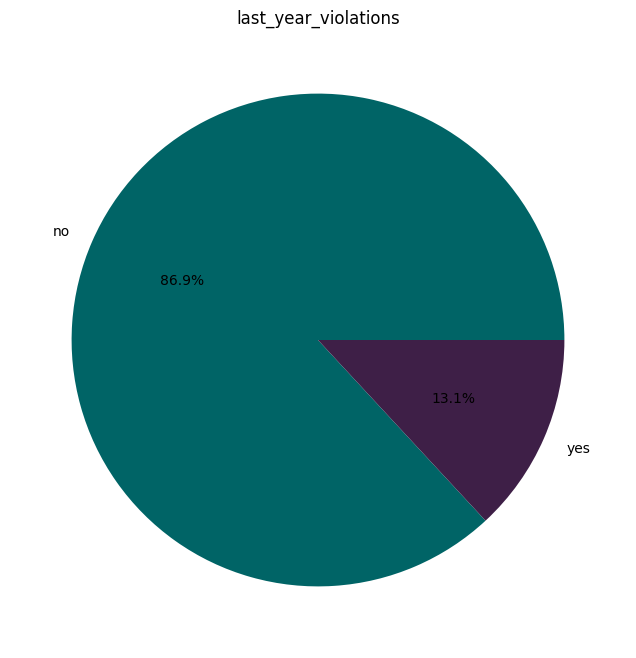

In [233]:
categorical_data(test)

В тестовых признаках статистика относительно совпадает с тренировочной выборкой

### Корреляционный анализ

In [234]:
train_job_satisfaction_rate

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,sales,junior,medium,2,no,no,1,24000,0.58
1,hr,junior,high,2,no,no,5,38400,0.76
2,sales,junior,low,1,no,no,2,12000,0.11
3,technology,junior,low,4,no,no,2,18000,0.37
4,hr,junior,medium,1,no,no,3,22800,0.20
...,...,...,...,...,...,...,...,...,...
3747,hr,sinior,high,6,no,no,4,80400,0.88
3748,sales,junior,medium,2,no,no,3,20400,0.27
3749,sales,middle,low,7,no,no,5,24000,0.76
3750,sales,junior,medium,2,no,no,3,24000,0.48


In [235]:
corr = train_job_satisfaction_rate.select_dtypes(include=['number']).corr(method='spearman')
corr.style.background_gradient(cmap='Purples')

,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
employment_years,1.000000,0.000606,0.461894,0.219495
supervisor_evaluation,0.000606,1.000000,0.006448,0.745266
salary,0.461894,0.006448,1.000000,0.122443
job_satisfaction_rate,0.219495,0.745266,0.122443,1.000000


### Вывод

Соотношение признаков в тренировочной и тестовой выборках совпадает. Некоторые категориальные признаки следует закодировать в определенной последовательности

## Подготовка данных (1)

### Пайплайн

In [236]:
train_job_satisfaction_rate.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,sales,junior,medium,2,no,no,1,24000,0.58
1,hr,junior,high,2,no,no,5,38400,0.76
2,sales,junior,low,1,no,no,2,12000,0.11
3,technology,junior,low,4,no,no,2,18000,0.37
4,hr,junior,medium,1,no,no,3,22800,0.20


In [237]:
X_train = train_job_satisfaction_rate.drop(['job_satisfaction_rate'], axis=1)
y_train = train_job_satisfaction_rate['job_satisfaction_rate']

In [238]:
X_train.shape

(3752, 8)

Разделим все колонки на количественные, категориальные и ранговые признаки


In [239]:
X_train.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,sales,junior,medium,2,no,no,1,24000
1,hr,junior,high,2,no,no,5,38400
2,sales,junior,low,1,no,no,2,12000
3,technology,junior,low,4,no,no,2,18000
4,hr,junior,medium,1,no,no,3,22800


In [240]:
ohe_columns  = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload', 'supervisor_evaluation']
num_columns = ['employment_years', 'salary']

Пайплайны с кодировщиками

In [241]:
data_preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_columns),
    ('cat_ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), ohe_columns),
    ('cat_ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ord_columns)
    ],
    remainder='passthrough'
)

In [242]:
test.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,marketing,junior,medium,2,no,no,5,28800,0.79
1,hr,junior,medium,1,no,no,4,30000,0.72
2,sales,middle,low,5,no,no,4,19200,0.64
3,sales,middle,low,6,no,no,4,19200,0.60
4,hr,middle,medium,5,no,no,5,40800,0.75


In [243]:
X_test = test.drop(['job_satisfaction_rate'], axis=1)
y_test = test['job_satisfaction_rate']

In [244]:
X_test.shape

(2000, 8)

### Вывод

Разделили все колонки на количественные, категориальные и ранговые; сделали пайплайн для предобработки данных - заполнения пропусков и кодирования

## Обучение моделей (1)

Обучим две модели - линейную регрессию и дерево решений

### Метрика SMAPE 

In [245]:
def metric(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    
    smape_value = np.mean(np.divide(numerator, denominator)) * 100
    return smape_value

In [246]:
smape = make_scorer(metric, greater_is_better=False)

### Подбор модели

In [247]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

In [248]:
param_grid = [
    {
        'models': [LinearRegression()],  
    },
    {
        'models': [DecisionTreeRegressor(random_state=42)],
        'models__max_depth': range(5, 15),
        'models__max_features': range(5, 15),
        'models__min_samples_leaf': range(2, 5),
    }
] 

In [249]:
rs = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring=smape,
    random_state=42,
    n_iter = 50,
    n_jobs=-1
)

In [250]:
rs.fit(X_train, y_train)
best_model = rs.best_estimator_

In [251]:
rs.best_score_

-15.4211596035567

In [252]:
pd.set_option('display.max_colwidth', None)
result = pd.DataFrame(rs.cv_results_)
result[['rank_test_score', 'param_models', 'mean_test_score','params']].sort_values('rank_test_score')

,rank_test_score,param_models,mean_test_score,params
42,1,DecisionTreeRegressor(random_state=42),-15.421160,"{'models__min_samples_leaf': 3, 'models__max_features': 11, 'models__max_depth': 14, 'models': DecisionTreeRegressor(random_state=42)}"
35,2,DecisionTreeRegressor(random_state=42),-15.463132,"{'models__min_samples_leaf': 3, 'models__max_features': 13, 'models__max_depth': 13, 'models': DecisionTreeRegressor(random_state=42)}"
1,3,DecisionTreeRegressor(random_state=42),-15.559154,"{'models__min_samples_leaf': 2, 'models__max_features': 11, 'models__max_depth': 14, 'models': DecisionTreeRegressor(random_state=42)}"
14,4,DecisionTreeRegressor(random_state=42),-15.604379,"{'models__min_samples_leaf': 3, 'models__max_features': 11, 'models__max_depth': 12, 'models': DecisionTreeRegressor(random_state=42)}"
21,5,DecisionTreeRegressor(random_state=42),-15.647789,"{'models__min_samples_leaf': 4, 'models__max_features': 13, 'models__max_depth': 13, 'models': DecisionTreeRegressor(random_state=42)}"
49,6,DecisionTreeRegressor(random_state=42),-15.666722,"{'models__min_samples_leaf': 2, 'models__max_features': 11, 'models__max_depth': 12, 'models': DecisionTreeRegressor(random_state=42)}"
22,7,DecisionTreeRegressor(random_state=42),-15.726602,"{'models__min_samples_leaf': 4, 'models__max_features': 14, 'models__max_depth': 12, 'models': DecisionTreeRegressor(random_state=42)}"
25,8,DecisionTreeRegressor(random_state=42),-15.763272,"{'models__min_samples_leaf': 4, 'models__max_features': 6, 'models__max_depth': 13, 'models': DecisionTreeRegressor(random_state=42)}"
31,9,DecisionTreeRegressor(random_state=42),-15.800390,"{'models__min_samples_leaf': 4, 'models__max_features': 8, 'models__max_depth': 14, 'models': DecisionTreeRegressor(random_state=42)}"
46,10,DecisionTreeRegressor(random_state=42),-15.816415,"{'models__min_samples_leaf': 4, 'models__max_features': 7, 'models__max_depth': 14, 'models': DecisionTreeRegressor(random_state=42)}"


In [253]:
smape(best_model, X_test, y_test)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


-13.733392471333177

In [254]:
best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['employment_years',
                                                   'salary']),
                                                 ('cat_ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('cat_ord',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['level', 'workload',
                                                   'supervisor_evaluation'])])),
                ('models',
                 DecisionTreeRegressor(max_depth=14, max_features=11,
                                       min_samples_leaf=3, random_state=42))])

## Вывод (1)

    Так как задача представляет собой регрессию для решения сравнивали две модели - линейную регрессию и DecisionTreeRegressor. Лучшая подобранная модель - DecisionTreeRegressor(max_depth=14, max_features=11, min_samples_leaf=3). Метрика на тестовой выборке - -13.7

## Загрузка данных (2)

In [255]:
train_quit = pd.read_csv('datasets/train_quit.csv')
test_features = pd.read_csv('datasets/test_features.csv')
test_target_quit = pd.read_csv('datasets/test_target_quit.csv')

In [256]:
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [257]:
test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [258]:
test_target_quit.head()

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


In [259]:
test = pd.merge(test_features, test_target_quit, on='id')

In [260]:
train_quit = train_quit.set_index('id')

In [261]:
test = test.set_index('id')

## Предобработка данных (2)

### Пропуски

In [262]:
passes(train_quit)

Пропуски:
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64
Количество записей: 4000


In [263]:
passes(test)

Пропуски:
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64
Количество записей: 2000


In [264]:
col = test.columns
passes_pipe.fit(train_quit)
res = passes_pipe.transform(test)
test = pd.DataFrame(res, columns=col)

In [265]:
passes(test)

Пропуски:
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64
Количество записей: 2000


### Неявные дубликаты

In [266]:
columns = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations', 'quit']
implicit_duplicates(train_quit, columns)

dept: sales | purchasing | marketing | technology | hr
level: middle | junior | sinior
workload: high | medium | low
last_year_promo: no | yes
last_year_violations: no | yes
quit: no | yes


In [267]:
columns = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']
implicit_duplicates(test, columns)

dept: marketing | hr | sales | purchasing | technology |  
level: junior | middle | sinior
workload: medium | low | high |  
last_year_promo: no | yes
last_year_violations: no | yes


### Явные дубликаты

In [268]:
duplicated(train_quit)

Количество пропусков: 1413


In [269]:
train_quit = train_quit.drop_duplicates()
train_quit = train_quit.reset_index(drop=True)

In [270]:
duplicated(test)

Количество пропусков: 506


In [271]:
duplicated(train_quit)

Количество пропусков: 0


### Типы данных

Проверим тип данных в каждом столбце

In [272]:
train_quit.dtypes

dept                     object
level                    object
workload                 object
employment_years          int64
last_year_promo          object
last_year_violations     object
supervisor_evaluation     int64
salary                    int64
quit                     object
dtype: object

In [273]:
train_quit.head(1)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,sales,middle,high,2,no,no,4,54000,no


In [274]:
test.dtypes

dept                     object
level                    object
workload                 object
employment_years         object
last_year_promo          object
last_year_violations     object
supervisor_evaluation    object
salary                   object
quit                     object
dtype: object

In [275]:
test.head(1)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,marketing,junior,medium,2,no,no,5,28800,no


In [276]:
test['employment_years'] = test['employment_years'].astype('int')
test['supervisor_evaluation'] = test['supervisor_evaluation'].astype('int')
test['salary'] = test['salary'].astype('int')

In [277]:
test.dtypes

dept                     object
level                    object
workload                 object
employment_years          int64
last_year_promo          object
last_year_violations     object
supervisor_evaluation     int64
salary                    int64
quit                     object
dtype: object

### Вывод

Заменили типы данных в некоторых столбцах test и заполнили пропуски

## Исследовательский анализ данных (2)

### Статистический анализ

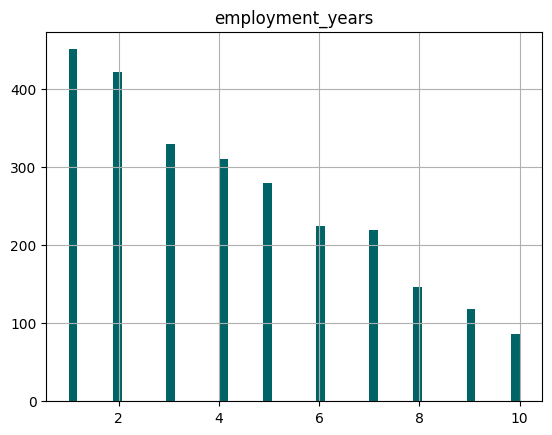

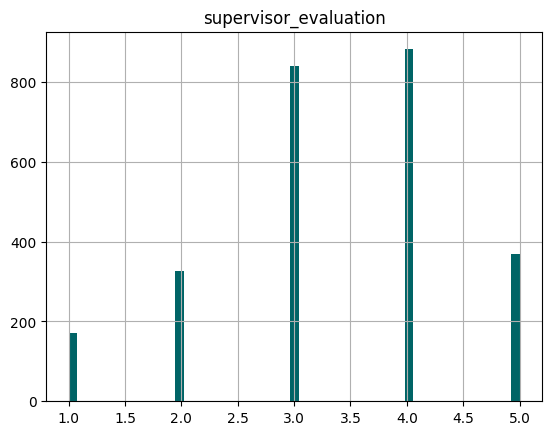

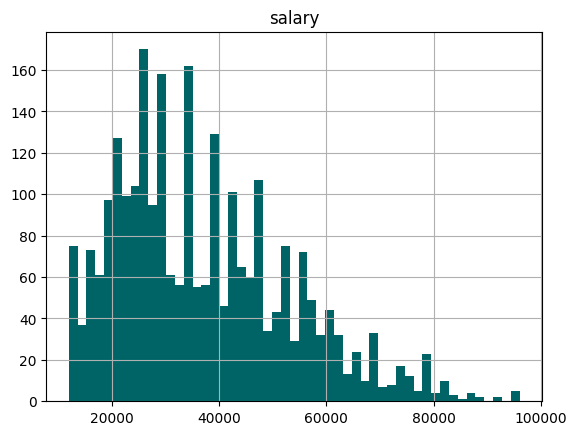

In [278]:
build_hist(train_quit)

Большинство сотрудников проработало около года в компании; оценка качества работы у сотрудников, как правило, 3-4; зарплата обычно в диапазоне от 20к до 40к

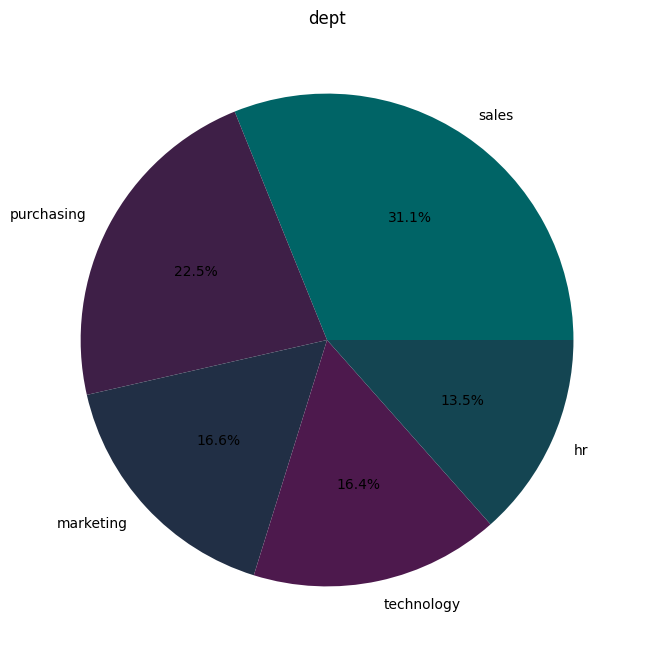

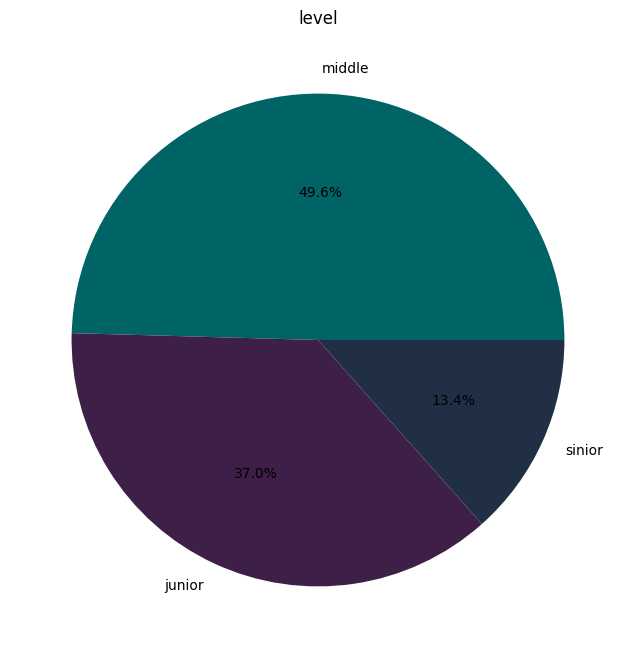

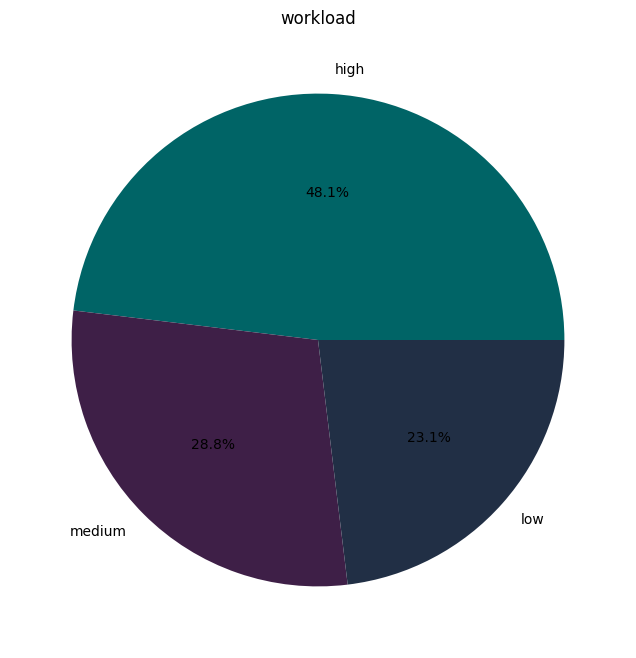

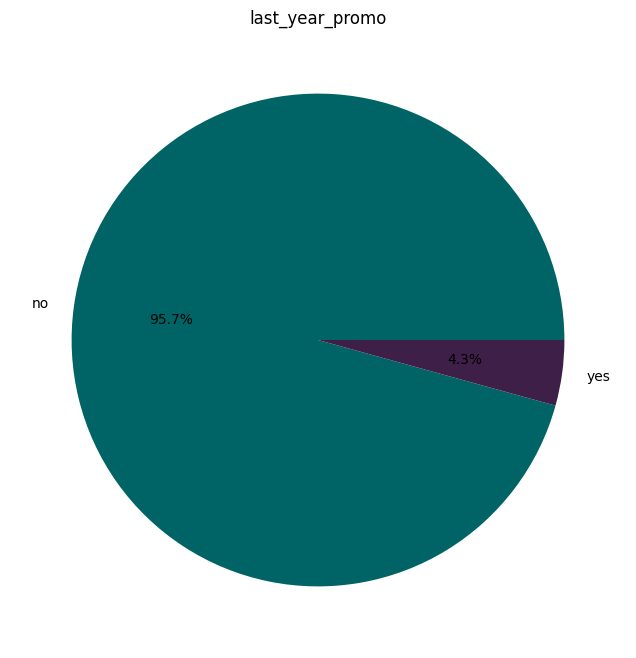

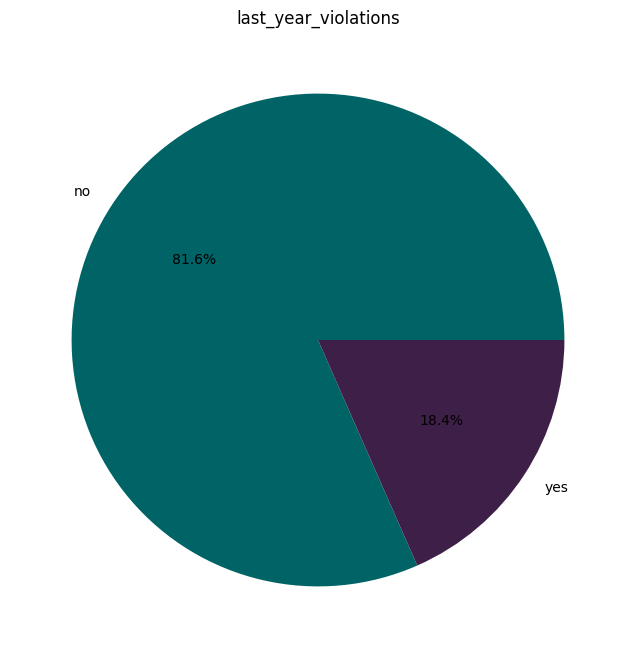

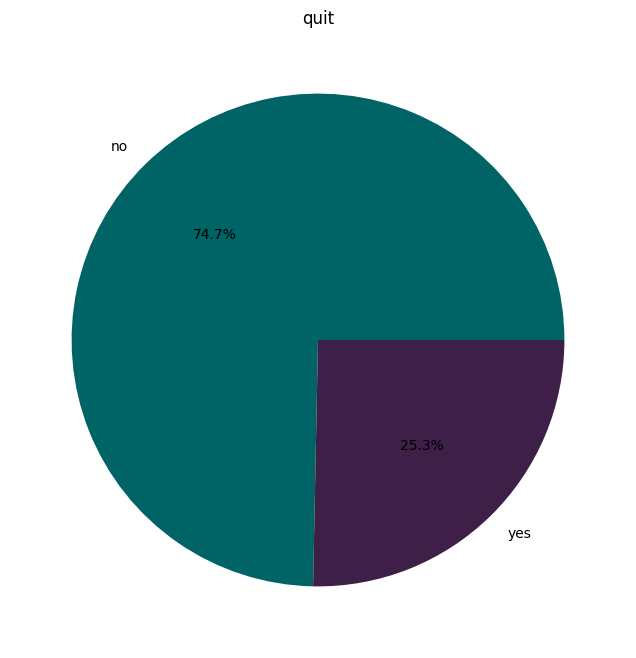

In [279]:
categorical_data(train_quit)

50% работников - средняя должность, меньше всего старших работников; уровень загруженности более, чем у половины сотрудников высокий; за последний год только у 3% было повышение; 1/4 сотрудников в датасете были уволены

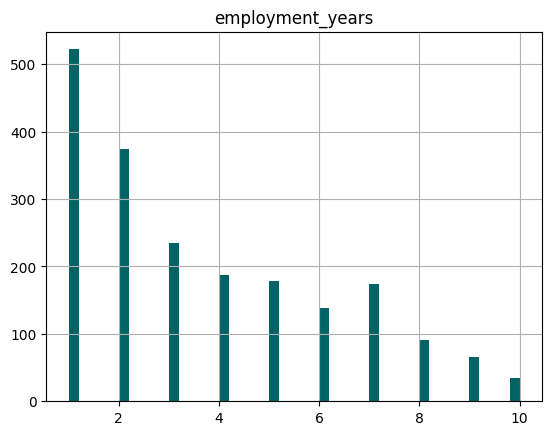

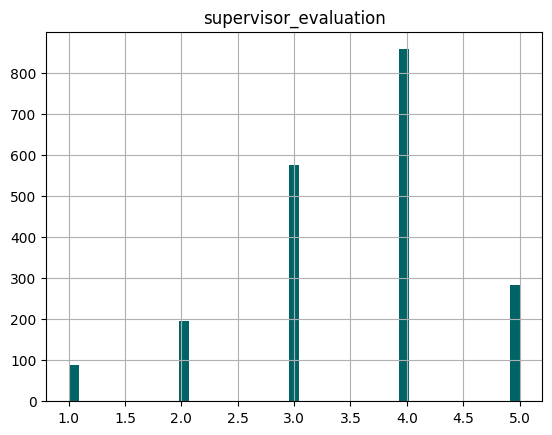

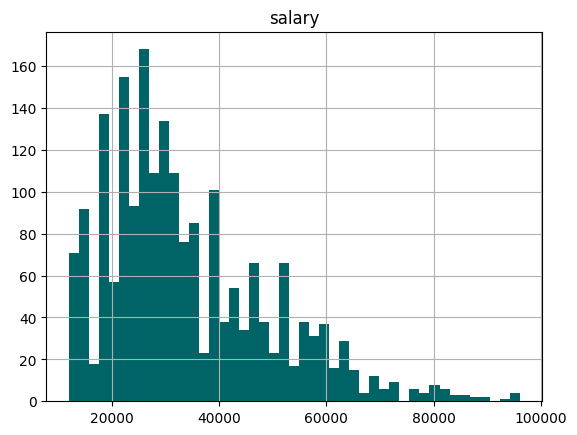

In [280]:
build_hist(test)

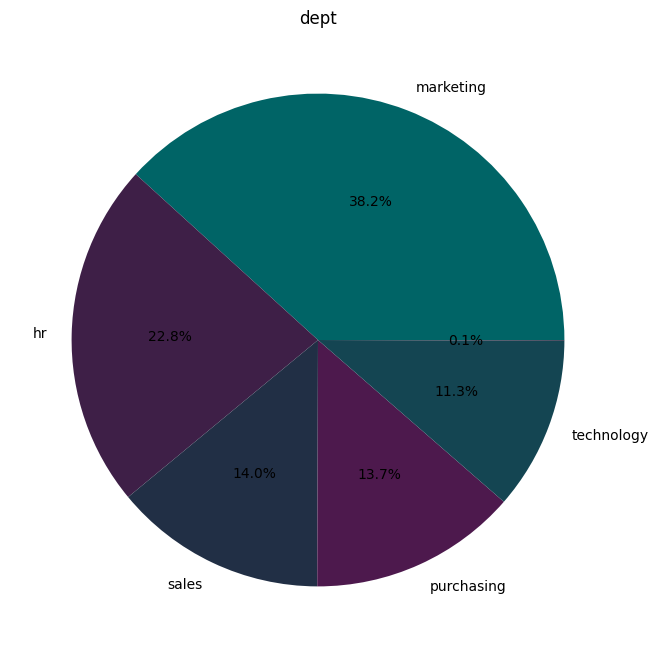

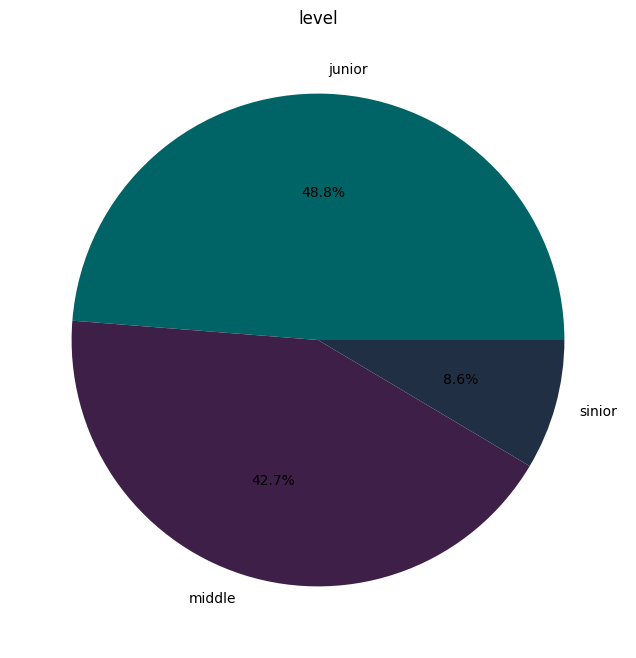

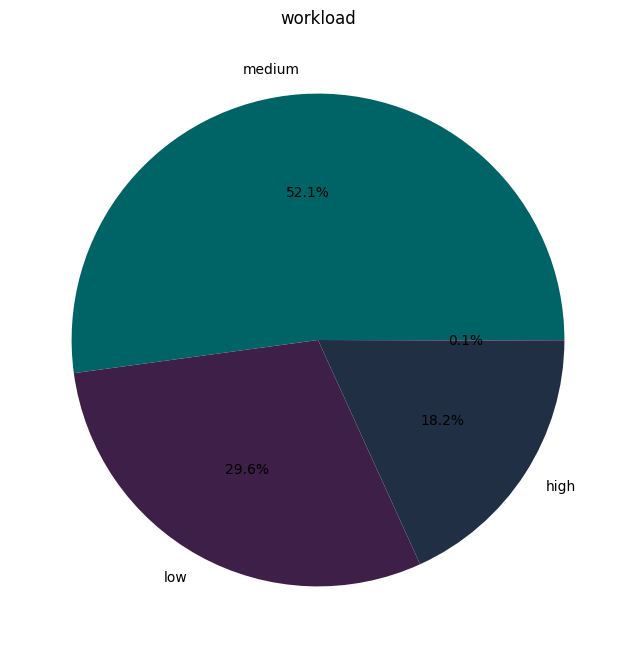

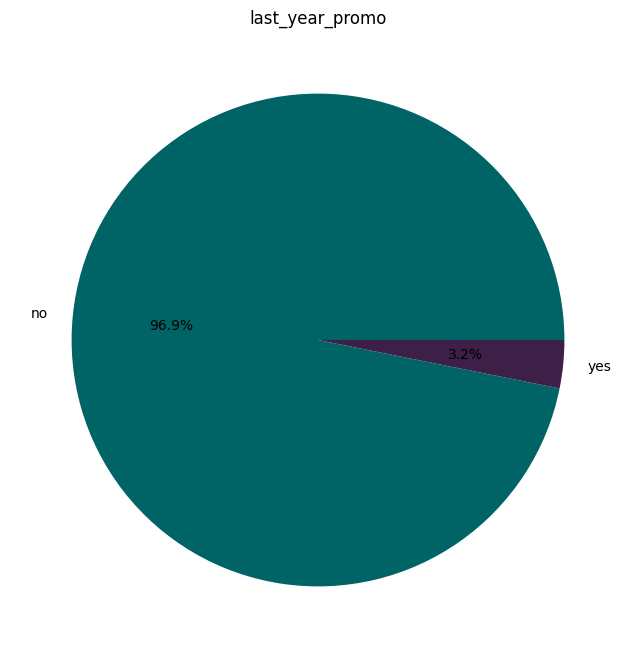

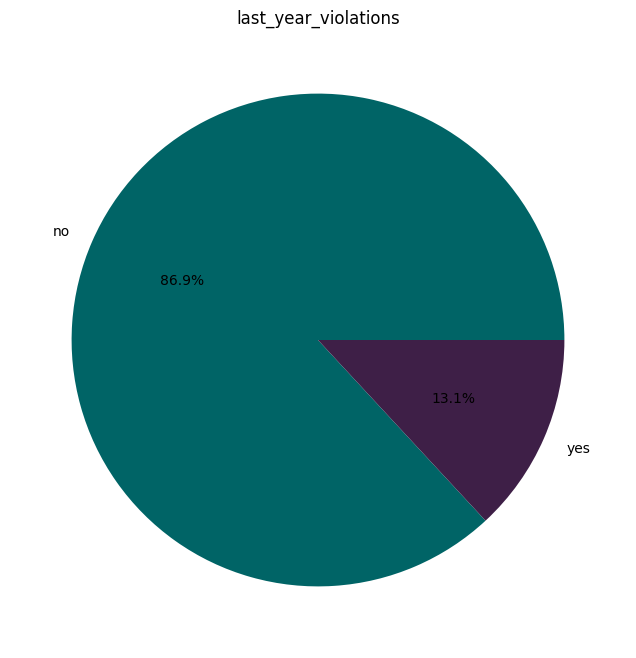

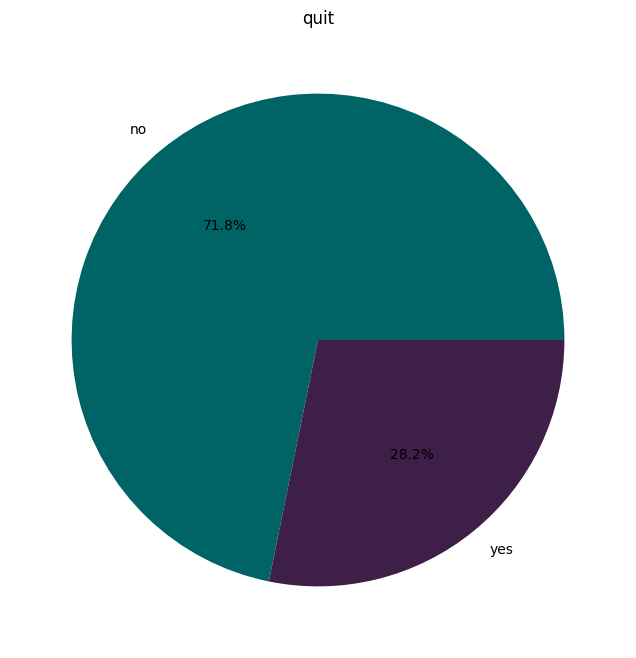

In [281]:
categorical_data(test)

В тестовой выборке уровень средней зарплаты сотрудников выше, чем в тренировочной; в целом распределение количественных и категориальных признаков в датасетах похожи

### Корреляционный анализ

In [282]:
corr = train_quit.corr(method='spearman')
corr.style.background_gradient(cmap='Purples')

ValueError: could not convert string to float: 'sales'

Признак зарплаты сильно коррелирует с стажем работы

### Портрет «уволившегося сотрудника»

Выберем только уволившихся сотрудников в тренировочном датасете

In [ ]:
retired_employee = train_quit[train_quit['quit'] == 'yes']

In [ ]:
retired_employee.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
3,sales,junior,medium,2,no,yes,3,24000,yes
5,sales,junior,low,1,no,yes,3,18000,yes
9,technology,middle,medium,2,no,no,3,45600,yes
24,technology,junior,medium,2,no,no,3,30000,yes
25,marketing,junior,medium,3,no,no,3,30000,yes


Построим гистрограммы для количественных признаков

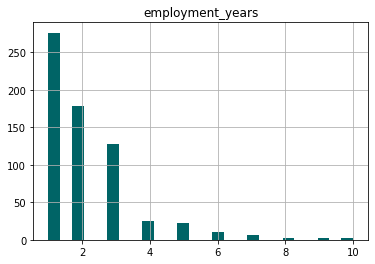

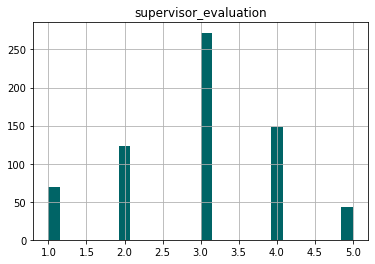

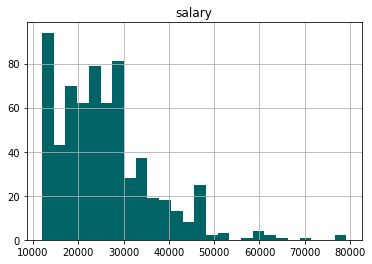

In [ ]:
build_hist(retired_employee)

Видим, что оценка работы у большинства уволившихся сотрудников - 3; зарплата находится в диапазоне от 10к до 30к, что меньше, чем в общем датасете

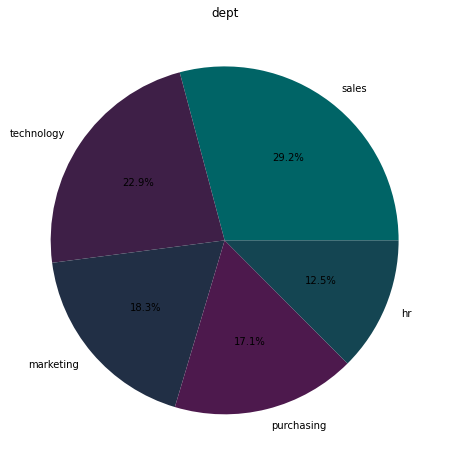

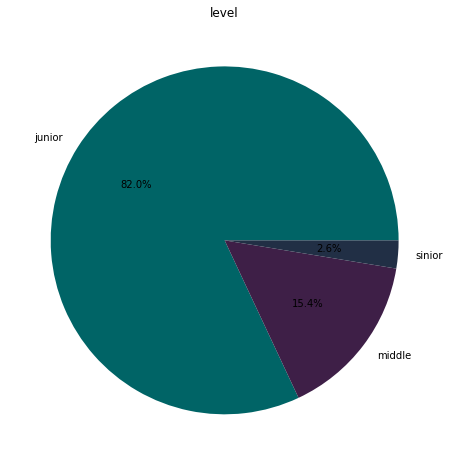

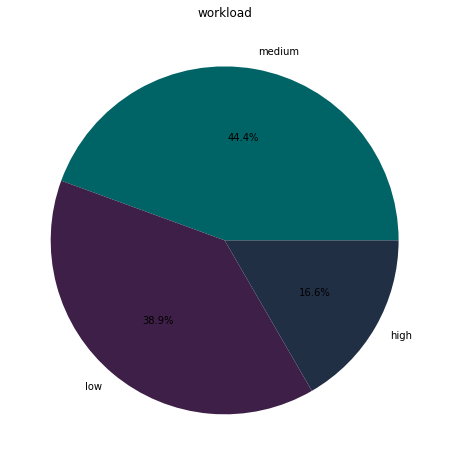

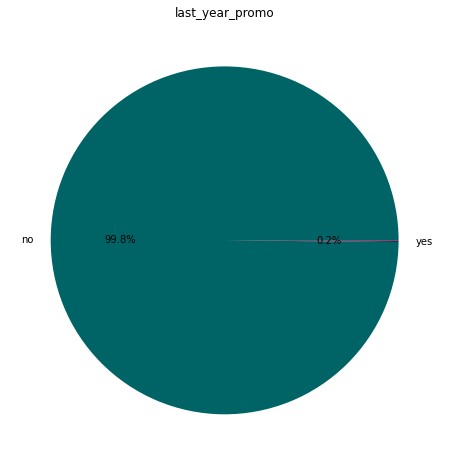

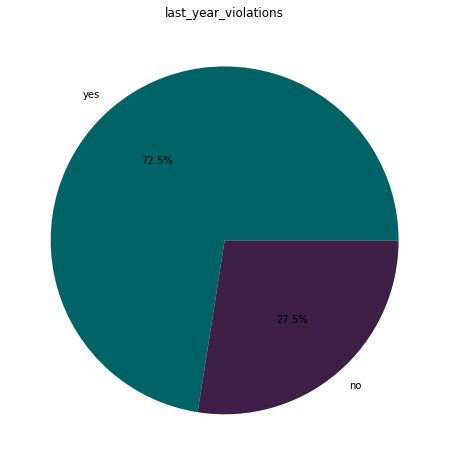

In [ ]:
categorical_data(retired_employee.drop(['quit'], axis=1))

In [ ]:
len(retired_employee[retired_employee['last_year_promo'] == 'yes'])

1

Увольняются, как правило, сотрудники низких должностей со средней загруженностью; почти ни у кого из уволившихся не было повышения за последний год; почти 80% из них нарушали трудовой договор за последний год

Сравним среднее значение зарплаты уволившихся и оставшихся сотрудников

In [ ]:
not_retired_employee = train_quit[train_quit['quit'] == 'no']
s1 = retired_employee['salary'].median()
s2 = not_retired_employee['salary'].median()
print(f'Средняя зарплата уволившегося сотрудника: {s1}')
print(f'Средняя зарплата оставшегося сотрудника: {s2}')

Средняя зарплата уволившегося сотрудника: 24000.0
Средняя зарплата оставшегося сотрудника: 39000.0


### Уровень удовлетворённости сотрудника

In [ ]:
quit_satisfaction = pd.merge(test_target_job_satisfaction_rate, test_target_quit, on='id')
quit_satisfaction.head()

,id,job_satisfaction_rate,quit
0,130604,0.74,no
1,825977,0.75,no
2,418490,0.60,yes
3,555320,0.72,no
4,826430,0.08,yes


In [ ]:
quit_satisfaction_retired = quit_satisfaction[quit_satisfaction['quit'] == 'yes'].drop(['quit', 'id'], axis=1)
quit_satisfaction_not_retired = quit_satisfaction[quit_satisfaction['quit'] == 'no'].drop(['quit', 'id'], axis=1)

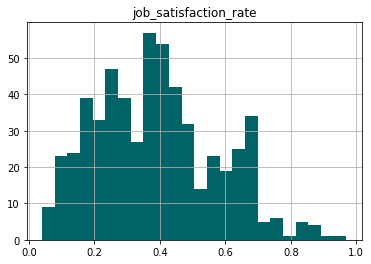

In [ ]:
build_hist(quit_satisfaction_retired)

* Уровень удовлетворенности работой уволившихся сотрудников составляет, как правило, от 0.2 до 0.5

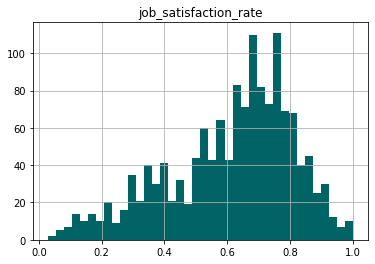

In [ ]:
build_hist(quit_satisfaction_not_retired)

* Уровень удовлетворенности работой оставшихся сотрудников составляет, как правило, от 0.6 до 0.75

## Добавление нового входного признака

Добавим job_satisfaction_rate, предсказанный лучшей моделью первой задачи, к входным признакам

In [ ]:
X_train_predicted = best_model.predict(train_quit)
X_test_predicted = best_model.predict(test)

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [ ]:
X_train.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,sales,junior,medium,2,no,no,1,24000
1,hr,junior,high,2,no,no,5,38400
2,sales,junior,low,1,no,no,2,12000
3,technology,junior,low,4,no,no,2,18000
4,hr,junior,medium,1,no,no,3,22800


In [ ]:
train_quit['job_satisfaction'] = X_train_predicted
test['job_satisfaction'] = X_test_predicted

In [ ]:
train_quit.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction
0,sales,middle,high,2,no,no,4,54000,no,0.653333
1,sales,junior,medium,2,no,no,4,27600,no,0.846364
2,purchasing,middle,medium,5,no,no,1,37200,no,0.326667
3,sales,junior,medium,2,no,yes,3,24000,yes,0.350000
4,marketing,junior,medium,2,no,no,5,25200,no,0.791667


In [ ]:
test.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction
0,marketing,junior,medium,2,no,no,5,28800,no,0.855000
1,hr,junior,medium,1,no,no,4,30000,no,0.678750
2,sales,middle,low,5,no,no,4,19200,no,0.690000
3,sales,middle,low,6,no,no,4,19200,no,0.713333
4,hr,middle,medium,5,no,no,5,40800,no,0.816667


## Подготовка данных (2)

In [ ]:
X_train = train_quit.drop(['quit'], axis=1)
y_train = train_quit['quit']
X_test = test.drop(['quit'], axis=1)
y_test = test['quit']

In [ ]:
ohe_columns  = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload', 'supervisor_evaluation']
num_columns = ['employment_years', 'salary', 'job_satisfaction']

In [ ]:
X_train.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction
0,sales,middle,high,2,no,no,4,54000,0.653333
1,sales,junior,medium,2,no,no,4,27600,0.846364
2,purchasing,middle,medium,5,no,no,1,37200,0.326667
3,sales,junior,medium,2,no,yes,3,24000,0.350000
4,marketing,junior,medium,2,no,no,5,25200,0.791667


In [ ]:
X_test.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction
0,marketing,junior,medium,2,no,no,5,28800,0.855000
1,hr,junior,medium,1,no,no,4,30000,0.678750
2,sales,middle,low,5,no,no,4,19200,0.690000
3,sales,middle,low,6,no,no,4,19200,0.713333
4,hr,middle,medium,5,no,no,5,40800,0.816667


## Обучение модели (2)

Задача представляет собой классификацию, обучим три модели: логистическую регрессию, дерево решений и KNN

In [ ]:
pipe = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LogisticRegression(random_state=42))
])

In [ ]:
param_grid = [
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),  
    },
    {
        'models': [DecisionTreeClassifier(random_state=42)],
        'models__max_depth': range(2, 15),
        'models__min_samples_split': range(2, 10),
        'models__min_samples_leaf': range(2, 5),
    },
    {
        'models': [LogisticRegression(random_state=42, solver='liblinear', penalty='l1', max_iter=1000)],
        'models__C': range(1, 5, 2),
    }
] 

In [ ]:
rs = RandomizedSearchCV(
    pipe,
    param_grid,
    n_jobs=-1,
    cv=5,
    scoring='roc_auc',
    random_state=42,
    n_iter=20
)

In [ ]:
rs.fit(X_train, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['employment_years',
                                                                                'salary']),
                                                                              ('cat_ohe',
                                                                               OneHotEncoder(drop='first',
                                                                                             handle_unknown='ignore',
                                                                                             sparse_output=False),
                                                                               ['dept',
                                                                                'last_year_promo',
                                                                                'last_year_violations']),
                                                                              ('cat_ord',
                                                                               OrdinalEncoder(handle_unknow...
                                         'models__n_neighbors': range(2, 5)},
                                        {'models': [DecisionTreeClassifier(random_state=42)],
                                         'models__max_depth': range(2, 15),
                                         'models__min_samples_leaf': range(2, 5),
                                         'models__min_samples_split': range(2, 10)},
                                        {'models': [LogisticRegression(max_iter=1000,
                                                                       penalty='l1',
                                                                       random_state=42,
                                                                       solver='liblinear')],
                                         'models__C': range(1, 5, 2)}],
                   random_state=42, scoring='roc_auc')

In [ ]:
best_model = rs.best_estimator_
best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['employment_years',
                                                   'salary']),
                                                 ('cat_ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('cat_ord',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['level', 'workload',
                                                   'supervisor_evaluation'])])),
                ('models',
                 DecisionTreeClassifier(max_depth=5, min_samples_leaf=3,
                                        min_samples_split=3,
                                        random_state=42))])

In [ ]:
pd.set_option('display.max_colwidth', None)
result = pd.DataFrame(rs.cv_results_)
result[['rank_test_score', 'param_models', 'mean_test_score','params']].sort_values('rank_test_score')

,rank_test_score,param_models,mean_test_score,params
15,1,DecisionTreeClassifier(random_state=42),0.900063,"{'models__min_samples_split': 3, 'models__min_samples_leaf': 3, 'models__max_depth': 5, 'models': DecisionTreeClassifier(random_state=42)}"
0,2,DecisionTreeClassifier(random_state=42),0.900017,"{'models__min_samples_split': 8, 'models__min_samples_leaf': 4, 'models__max_depth': 4, 'models': DecisionTreeClassifier(random_state=42)}"
8,2,DecisionTreeClassifier(random_state=42),0.900017,"{'models__min_samples_split': 6, 'models__min_samples_leaf': 3, 'models__max_depth': 4, 'models': DecisionTreeClassifier(random_state=42)}"
11,4,DecisionTreeClassifier(random_state=42),0.898182,"{'models__min_samples_split': 2, 'models__min_samples_leaf': 2, 'models__max_depth': 5, 'models': DecisionTreeClassifier(random_state=42)}"
9,5,DecisionTreeClassifier(random_state=42),0.891164,"{'models__min_samples_split': 3, 'models__min_samples_leaf': 4, 'models__max_depth': 6, 'models': DecisionTreeClassifier(random_state=42)}"
17,6,DecisionTreeClassifier(random_state=42),0.885862,"{'models__min_samples_split': 3, 'models__min_samples_leaf': 3, 'models__max_depth': 7, 'models': DecisionTreeClassifier(random_state=42)}"
5,7,DecisionTreeClassifier(random_state=42),0.885040,"{'models__min_samples_split': 4, 'models__min_samples_leaf': 2, 'models__max_depth': 6, 'models': DecisionTreeClassifier(random_state=42)}"
12,8,DecisionTreeClassifier(random_state=42),0.879571,"{'models__min_samples_split': 3, 'models__min_samples_leaf': 4, 'models__max_depth': 8, 'models': DecisionTreeClassifier(random_state=42)}"
10,9,DecisionTreeClassifier(random_state=42),0.879521,"{'models__min_samples_split': 6, 'models__min_samples_leaf': 4, 'models__max_depth': 11, 'models': DecisionTreeClassifier(random_state=42)}"
18,10,DecisionTreeClassifier(random_state=42),0.876106,"{'models__min_samples_split': 7, 'models__min_samples_leaf': 4, 'models__max_depth': 14, 'models': DecisionTreeClassifier(random_state=42)}"


In [ ]:
y_proba = best_model.predict_proba(X_train)[:, 1]
roc_auc = roc_auc_score(y_train, y_proba)
roc_auc

0.9340149036713922

In [ ]:
y_proba = best_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_proba)
roc_auc

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


0.925043585412592

## Вывод (2)

    Наилучшая модель - дерево решений с гиперпараметрами: max_depth=5, min_samples_leaf=3, min_samples_split=3. Метрика на тестовой выборке - 0.93. Все первые строки занимают модели DecisionTree, вероятно, из-за наиболее гибких настроек.

## Общий вывод

В этом проекте помогли компании «Работа с заботой» оптимизировать управление персоналом - с помощью моделей предсказали уровень удовлетворенности сотрудников и увольнения.

Для этого в каждой задаче выполнили следующие действия:
* Проанализировали данные сотрудников;
* Сделали необходимую предобработку - заполнили пропуски в пайплайне и поменяли типы данных;
* Обучили модели в задаче регрессии - линейную регрессию и дерево решений;
* Реализовали метрику SMAPE;
* Добавили новый входной признак;
* Обучили три модели классификации - дерево решений, логистическую регрессию и KNN. 

Наиболее удачными моделями оказались деревья решений

Для удержания сотрудников следует улучшать качество условий труда. Особенно это касается младших специалистов. На уровень удовлетворенности работой сильно влияет заработная плата, уровень загруженности сотрудника и уровень занимаемой должности.